# Esercizio

Data Set Information:

I dati sono stati estratti da immagini prese da esemplari autentici e falsificati di banconote. Per la digitalizzazione è stata utilizzata una telecamera industriale solitamente utilizzata per l'ispezione delle stampe. Le immagini finali hanno una risoluzione di 400x400 pixel. Grazie all'obiettivo dell'oggetto e alla distanza dall'oggetto indagato sono state ottenute immagini in scala di grigi con una risoluzione di circa 660 dpi. Per estrarre le caratteristiche dalle immagini è stato utilizzato lo strumento Wavelet Transform.

Attribute Information:

1. varianza dell'immagine trasformata (variabile continua)
2. asimmetria dell'immagine trasformata (variabile continua)
3. curtosi dell'immagine trasformata (variabile continua)
4. entropia dell'immagine (variabile continua)
5. classe (variabile intera: 0 la banconota è autentica, 1 la banconota è falsa)

Utilizzare il metodo di classificazione decision tree per determinare se la seguente banconota è vera o è falsa:

In [2]:
from tabulate import tabulate

info = ['Variance', 'Skewness', 'Curtosis', 'Entropy']
daScoprire = [-3.0866, -6.6362, 10.5405, -0.89182] 
print(tabulate([daScoprire], headers=info))

  Variance    Skewness    Curtosis    Entropy
----------  ----------  ----------  ---------
   -3.0866     -6.6362     10.5405   -0.89182


In [3]:
# importiamo Pandas e il datafarame dal file data/bill.csv
import pandas as pd
df = pd.read_csv('data/bills.csv')

In [4]:
# visualizziamo il dataframe
df.head(5)

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [5]:
# visualizziamo il numero di banconote per ogni classe
print(df.groupby('Class').size())

Class
0    762
1    610
dtype: int64


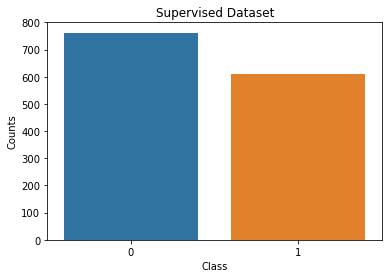

In [6]:
# per maggior chiarezza, visualizziamo anche il grafico delle classi delle banconote
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Class", data=df)
plt.title("Supervised Dataset")
plt.xlabel("Class")
plt.ylabel("Counts")
plt.show()

In [7]:
# traformiamo il dataframe in una matrice numpy e separiamo il target (la classe, ultima colonna, che chiamiamo y)
# dal resto dei dati (le osservazioni, che chiameremo x)
import numpy as np

dfnp = df.to_numpy()
x=dfnp[:,0:-1] # prendiamo tutti i dati tranne l'ultima colonna -> variabili indipendenti, osservazioni
y=dfnp[:,-1] # prendiamo solo l'ultima colonna -> variabile dipendente, target 


In [8]:
# vediamo i dati presenti in x e y
print(x[:10])
print(f'y = {y[:10]}')

[[ 3.6216   8.6661  -2.8073  -0.44699]
 [ 4.5459   8.1674  -2.4586  -1.4621 ]
 [ 3.866   -2.6383   1.9242   0.10645]
 [ 3.4566   9.5228  -4.0112  -3.5944 ]
 [ 0.32924 -4.4552   4.5718  -0.9888 ]
 [ 4.3684   9.6718  -3.9606  -3.1625 ]
 [ 3.5912   3.0129   0.72888  0.56421]
 [ 2.0922  -6.81     8.4636  -0.60216]
 [ 3.2032   5.7588  -0.75345 -0.61251]
 [ 1.5356   9.1772  -2.2718  -0.73535]]
y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
# ora contiamo le classi che sono presenti nella y per vedere se corrispondono a quanto trovato nel dataframe
import collections
collections.Counter(y)

Counter({0.0: 762, 1.0: 610})

In [23]:
#suddividiamo ora i dati in due dataset, uno per 'allenare' il metodo (training set) 
# e l'altro per testarne l'efficacia (test set). Facciamo in modo che il training set sia il 75% del totale
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size =0.25, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify=y,
                                                    random_state= 123) #fix random seed for replicability

In [11]:
# visualizziamo gli shape dei vari dataset X_train, X_test, y_train e y_test
X_train.shape,y_train.shape,X_test.shape,y_test.shape 

((1029, 4), (1029,), (343, 4), (343,))

In [24]:
# visualizziamo anche le prime 10 righe dell'X_train e dell'y_train per vedere i dati
# eliminiamo la notazione scientifica per comodità di lettura
np.set_printoptions(suppress=True)
print(X_train[:10])
print(f'y_train = {y_train[:10]}')

[[  0.16358  -3.3584    1.3749    1.3569 ]
 [  3.5156   10.1891   -4.2759   -4.978  ]
 [  1.8993    7.6625    0.15394  -3.1108 ]
 [  2.2517   -5.1422    4.2916   -1.2487 ]
 [ -1.7713  -10.7665   10.2184   -1.0043 ]
 [  3.6244    1.4609    1.3501    1.9284 ]
 [  2.6606    3.1681    1.9619    0.18662]
 [  4.9264    5.496    -2.4774   -0.50648]
 [ -2.7611  -10.5099    9.0239   -1.9547 ]
 [  4.5597   -2.4211    2.6413    1.6168 ]]
y_train = [1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


In [13]:
# importiamo il metodo di classificazione decision tree
from sklearn import tree

In [29]:
# inizializziamo il metodo con i seguenti parametri:
# criterio: indice di Gini
# profondità massima dell'albero: 8
# dimensione minima per lo split: 25
# numero di campioni delle foglie: 10
tree_clf = tree.DecisionTreeClassifier(criterion="gini", # criteri per stabilire come splittare
                                       max_depth=8, # profondità dell'albero per evitare l'overfitting
                                       min_samples_split=25, # dimensione minima del sottogruppo a cui fermarsi (no more split)
                                       max_leaf_nodes=10, # numero dei nodi foglia
                                       min_samples_leaf=10 # numero di campioni per essere una foglia
                                      )


In [30]:
# "alleniamo" il metodo con i dati del training set
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=10, min_samples_leaf=10,
                       min_samples_split=25)

In [31]:
# proviamo a fare una previsione sui dati del test set
predict = tree_clf.predict(X_test)


In [17]:
# e visualizziamo il risultato (solo i primi dieci vini)
print(f'dati predetti dal metodo =                {predict[:10]}') # dati predetti dal metodo
print(f'dati reali presenti nel dataset di test = {y_test[:10]}') # dati effettivi presenti nel test set

dati predetti dal metodo =                [1. 0. 1. 1. 1. 0. 1. 0. 0. 0.]
dati reali presenti nel dataset di test = [0. 0. 1. 1. 1. 0. 1. 0. 0. 1.]


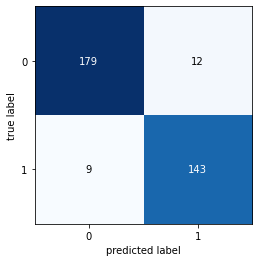

In [32]:
# valutiamo il nostro metodo:

# visualizziamo la confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

plot_confusion_matrix(confusion_matrix(y_test, predict))
plt.show()

In [24]:
# quanto valgono TP, FP, FN e TN?
# TP =
# FP =
# FN =
# TN =

In [25]:
# sulla base della confusion matrix, cosa possiamo dire di questo metodo? Motivare la risposta
# risposta:

In [35]:
# visualizziamo ora gli indicatori classici:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       191
         1.0       0.92      0.94      0.93       152

    accuracy                           0.94       343
   macro avg       0.94      0.94      0.94       343
weighted avg       0.94      0.94      0.94       343



In [27]:
# sulla base degli indicatori, che cosa possiamo dire del nostro metodo? Motivare la risposta
# risposta: Che è affidabile al 94%

In [37]:
# visualizziamo ora il decision tree, prima in forma testuale
from sklearn.tree.export import export_text
r = export_text(tree_clf, feature_names=features[0:-1])
print(r)

ModuleNotFoundError: No module named 'sklearn.tree.export'

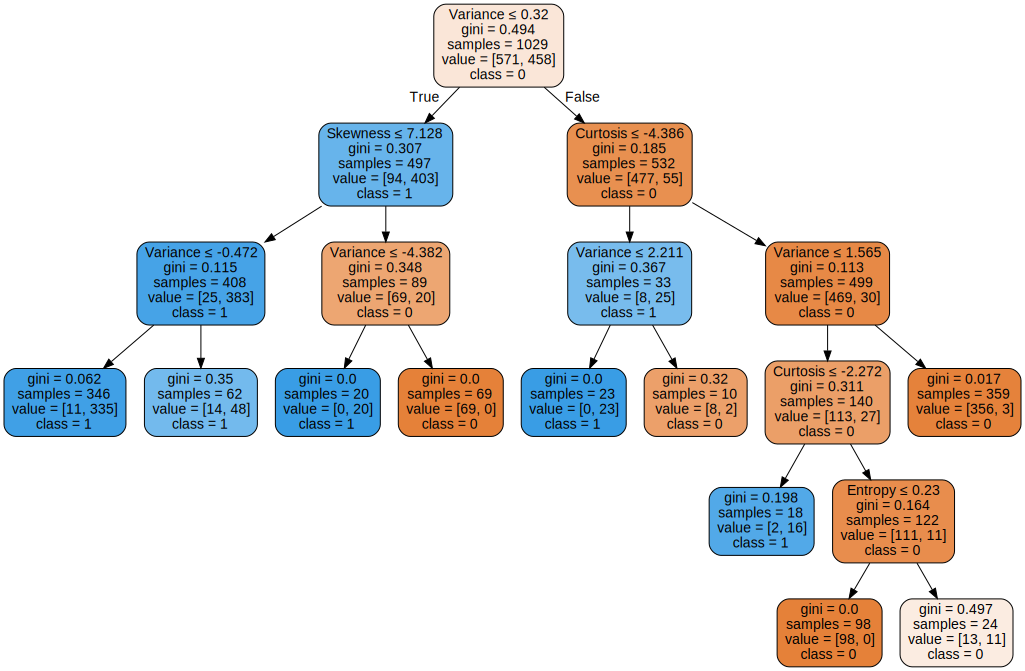

In [34]:
# e poi in forma grafica
#save the feature list into a vector (sono i nomi delle colonne del dataset)
features=list(df.columns.values)

import graphviz
dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                     feature_names=features[0:-1],  
                     class_names=['0','1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render('diabetes')
graph

In [38]:
# proviamo a determinare adesso se la banconota 
# di cui abbiamo avuto le caratteristiche all'inizio dell'esercizio è vera o è falsa:
from tabulate import tabulate

info = ['Variance', 'Skewness', 'Curtosis', 'Entropy']
daScoprire = [-3.0866, -6.6362, 10.5405, -0.89182] 
#print(tabulate([daScoprire], headers=info))
daScoprire = [[-3.0866, -6.6362, 10.5405, -0.89182]]
predictDaScoprire = tree_clf.predict(daScoprire)
predictDaScoprire


array([1.])

In [24]:
# la banconota è vera o falsa?
# risposta: vera

In [39]:
# la banconota che abbiamo testato in realtà è una di quelle giè presenti nel dataset. 
# Provate ad andare a vedere nel dataframe Pandas se la predizione del metodo è corretta o meno
# cercando alcune caratteristiche delòa nostra banconota, ad esempio 'Variance' = -3.0866, 'Skewness' = -6.6362 e
# 'Curtosis' = 10.5405
df[(df['Variance'] == -3.0866) & (df['Skewness'] == -6.6362) & (df['Curtosis'] == 10.5405)]

,Variance,Skewness,Curtosis,Entropy,Class
998,-3.0866,-6.6362,10.5405,-0.89182,1


In [26]:
# il metodo ha predetto correttamente il risultato?
# risposta: vera